In [178]:
import pandas as pd
import river
from pprint import pprint
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import optim
from river import feature_extraction
from river import stats
import itertools
import datetime as dt
from river import ensemble
from river import stream
from river import datasets
from river import facto
from river import compat
from river import metrics
import matplotlib.pyplot as plt
from river import tree
from river import neighbors
from river import multioutput
from river import neural_net
from river import dummy
from river import compat
from river import time_series
import numpy as np
import matplotlib.patches as mpatches
import time
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

In [3]:
# caricamente dati volume idrico

path_idra = '/home/giodefa/PycharmProjects/Script_Tesi_new/Dati/Urban Water Demand Data.txt'

def load_idraulic_press_data(data_path):

       dati = pd.read_csv(path_idra, sep='\t', index_col=False, header=0, names=('date','00:00-00:59','01:00-01:59','02:00-02:59','03:00-03:59','04:00-04:59','05:00-05:59','06:00-06:59','07:00-07:59','08:00-08:59','09:00-09:59','10:00-10:59','11:00-11:59','12:00-12:59','13:00-13:59','14:00-14:59','15:00-15:59','16:00-16:59','17:00-17:59','18:00-18:59','19:00-19:59','20:00-20:59','21:00-21:59','22:00-22:59','23:00-23:59'))


       date = dati.date
       dati = dati.drop("date", axis= 1)

       dati = dati.stack().reset_index()

       list_date = []
       for i in date:
              for a in range(0,24):
                     list_date.append(i)

       list_hour = []
       i = 0
       for a in range(0,dati.shape[0]):
              list_hour.append(i)
              i +=1
              if(i == 24):
                     i=0


       dati['date'] = list_date

       dati = dati.rename(columns = {'level_0':'Count_days','level_1':'Hours',0:'Water_volume'})
       dati = dati[['Count_days','date','Hours','Water_volume']]


       dati['date'] = pd.to_datetime(dati['date'], format='%d-%m-%Y')


       dati['days'] = dati['date'].dt.day

       dati['month'] =  dati['date'].dt.month

       dati['hour'] =  list_hour

       return dati

dati = load_idraulic_press_data(path_idra)
dati.to_csv('dativolum.csv')

def initial_iter_idraulic():

       path = '/home/giodefa/PycharmProjects/Script_Tesi_new/Script/DatiTesi/dativolum.csv'

       X_y = stream.iter_csv(
              filepath_or_buffer=path,
              converters={
                     'Count_days': int,
                     'Water_volume': float,
                     'days': int,
                     'month': int,
                     'hour': int,
                     '': int
                     },
              parse_dates={'date': '%Y-%m-%d'},
              target='Water_volume'
                      )
       return X_y

/tmp/ipykernel_20010/3318043435.py:7: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dati = pd.read_csv(path_idra, sep='\t', index_col=False, header=0, names=('date','00:00-00:59','01:00-01:59','02:00-02:59','03:00-03:59','04:00-04:59','05:00-05:59','06:00-06:59','07:00-07:59','08:00-08:59','09:00-09:59','10:00-10:59','11:00-11:59','12:00-12:59','13:00-13:59','14:00-14:59','15:00-15:59','16:00-16:59','17:00-17:59','18:00-18:59','19:00-19:59','20:00-20:59','21:00-21:59','22:00-22:59','23:00-23:59'))


# Water Volume Prediction

Abbiamo ora la messa al confronto degli 8 modelli selezionati. Quindi verrà fatto un confronto modello batch vs modello online per 4 volte e verranno mostrate sicuramente i plot dei risultati - le metriche di MSE e MAE per il confronto e la velocità di training del modello. All'interno della tesi invece verranno mostrate anche la complessità dei modelli. Poi verranno aggiunte anche le metriche reali di MAE e MSE per i modelli messi in produzione.

## MLP Online vs MLP Batch

### MLP Online

100%|██████████| 8496/8496 [00:07<00:00, 1065.86it/s]


Execution time: 7.974549770355225 seconds


Text(0.5, 1.0, 'MSE: 12,709,253.218966')

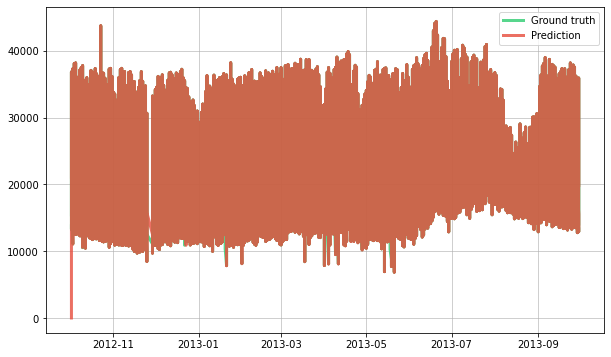

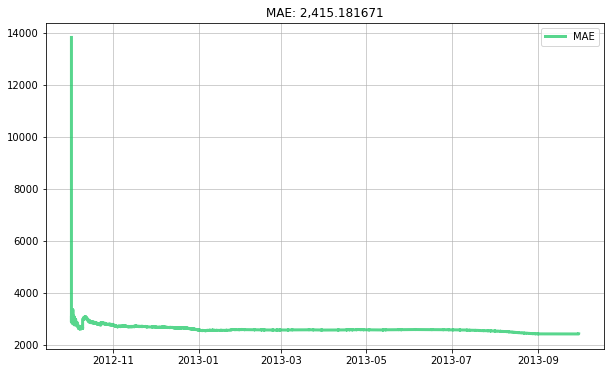

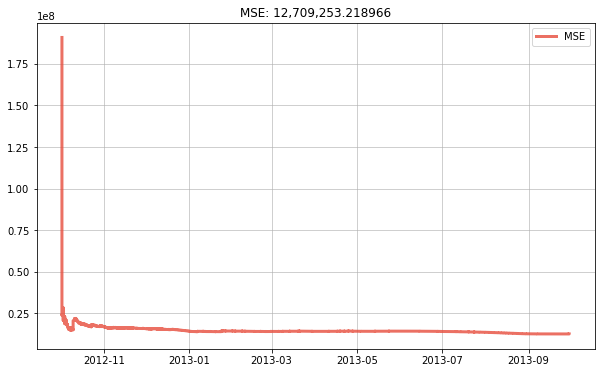

In [9]:
metric_mae_ml_online = metrics.MAE()
metric_mse_ml_online = metrics.MSE()

dates_ml_online = []
y_trues_ml_online = []
y_preds_ml_online = []
metrics_MAE_ml_online = []
metrics_MSE_ml_online = []

X_y = initial_iter_idraulic()

model = compose.Select()
model |= (
       preprocessing.StandardScaler() |
       neural_net.MLPRegressor(
              hidden_dims=(8, 16),
              activations=(
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.Identity
              ),
              optimizer=optim.SGD(0.5),

       )
)

# get the start time
st = time.time()

for i in tqdm(range(0,8496)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric ultimo 30%
       metric_mae_ml_online.update(y, y_pred)
       metric_mse_ml_online.update(y, y_pred)
       metrics_MAE_ml_online.append(metric_mae_ml_online.get())
       metrics_MSE_ml_online.append(metric_mse_ml_online.get())

       # Store the true value and the prediction
       dates_ml_online.append(x['date'])
       y_trues_ml_online.append(y)
       y_preds_ml_online.append(y_pred)

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ml_online, y_trues_ml_online, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates_ml_online, y_preds_ml_online, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ml_online, metrics_MAE_ml_online, lw=3, color='#2ecc71', alpha=0.8, label='MAE')
ax.legend()
ax.set_title(metric_mae_ml_online)


fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ml_online, metrics_MSE_ml_online, lw=3, color='#e74c3c', alpha=0.8, label='MSE')
ax.legend()
ax.set_title(metric_mse_ml_online)

In [62]:
X_y = initial_iter_idraulic()
model = compose.Select()
model |= (
       preprocessing.StandardScaler() |
       neural_net.MLPRegressor(
              hidden_dims=(8, 16),
              activations=(
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.Identity
              ),
              optimizer=optim.SGD(0.005),

       )
)

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MAE(),
       moment='date',
       delay=dt.timedelta(hours=3),
       print_every=3000
)

[3,000] MAE: 7,141.944032
[6,000] MAE: 6,950.219517


MAE: 6,514.380636

In [60]:
X_y = initial_iter_idraulic()
model = compose.Select()
model |= (
       preprocessing.StandardScaler() |
       neural_net.MLPRegressor(
              hidden_dims=(8, 16),
              activations=(
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.Identity
              ),
              optimizer=optim.SGD(0.005),

       )
)

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MSE(),
       moment='date',
       delay=dt.timedelta(hours=3),
       print_every=3000
)

[3,000] MSE: 72,969,338.659387
[6,000] MSE: 67,274,159.022122


MSE: 60,000,966.283311

### MLP Batch

In [138]:

X_mlp = dati['Water_volume'].to_numpy()
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return X, y

# split into samples
X_mlp, y_mlp = split_sequence(X_mlp, 1)

X_train_mlp, X_test_mlp, Y_train_mlp, Y_test_mlp = train_test_split(X_mlp, y_mlp, random_state=1, train_size=0.7, shuffle=False)

# get the start time
st = time.time()

regr_mlp = MLPRegressor(random_state=1, max_iter=2000, hidden_layer_sizes=(8,16)).fit(X_train_mlp, Y_train_mlp)
mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))




result_mlpBatch = regr_mlp.predict(X_test_mlp).reshape(-1,1)

et = time.time()

# get the execution time

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 0.2805182933807373 seconds


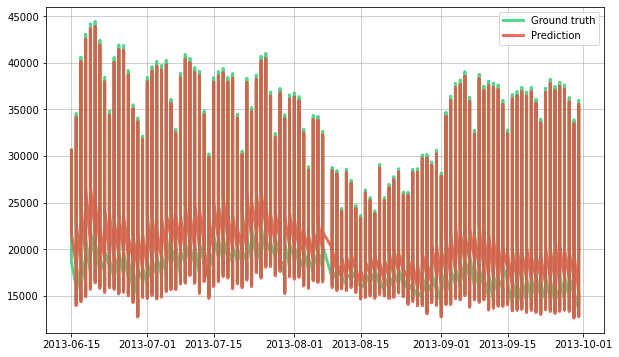

In [139]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ml_online[-2549::], Y_test_mlp, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates_ml_online[-2549::], result_mlpBatch, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

### Confronto MLP Batch vs MLP Online

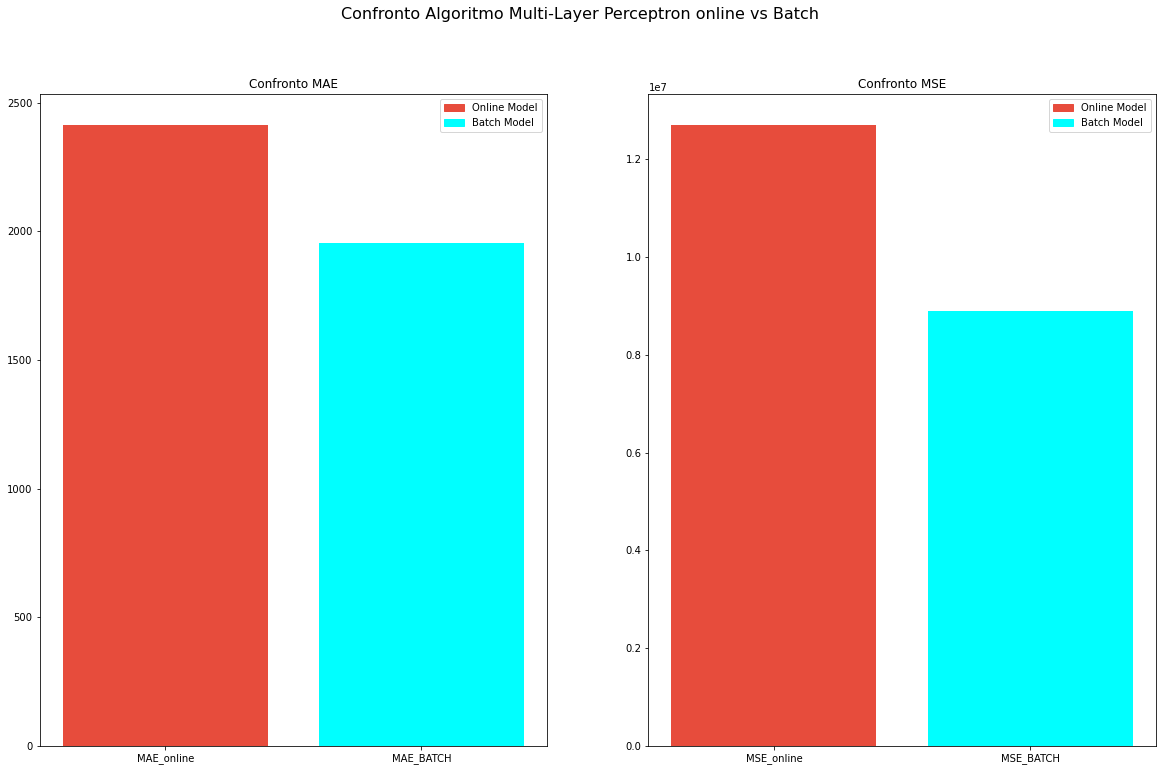

In [223]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Multi-Layer Perceptron online vs Batch',  fontsize=16)

ax1.bar(height=[metrics_MAE_ml_online[-1],mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[metrics_MSE_ml_online[-1],mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

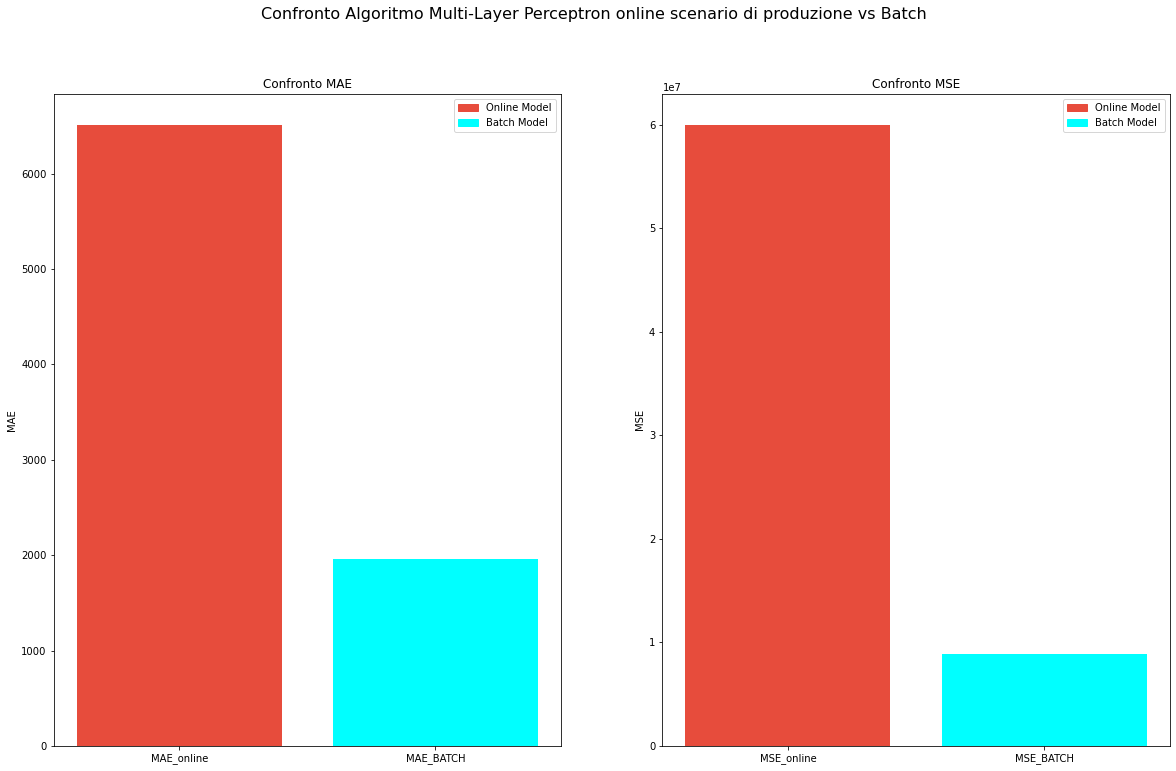

In [224]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Multi-Layer Perceptron online scenario di produzione vs Batch',  fontsize=16)

ax1.bar(height=[6514.380636,mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax1.set_ylabel('MAE')
ax2.bar(height=[60000966.283311,mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')
ax2.set_ylabel('MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

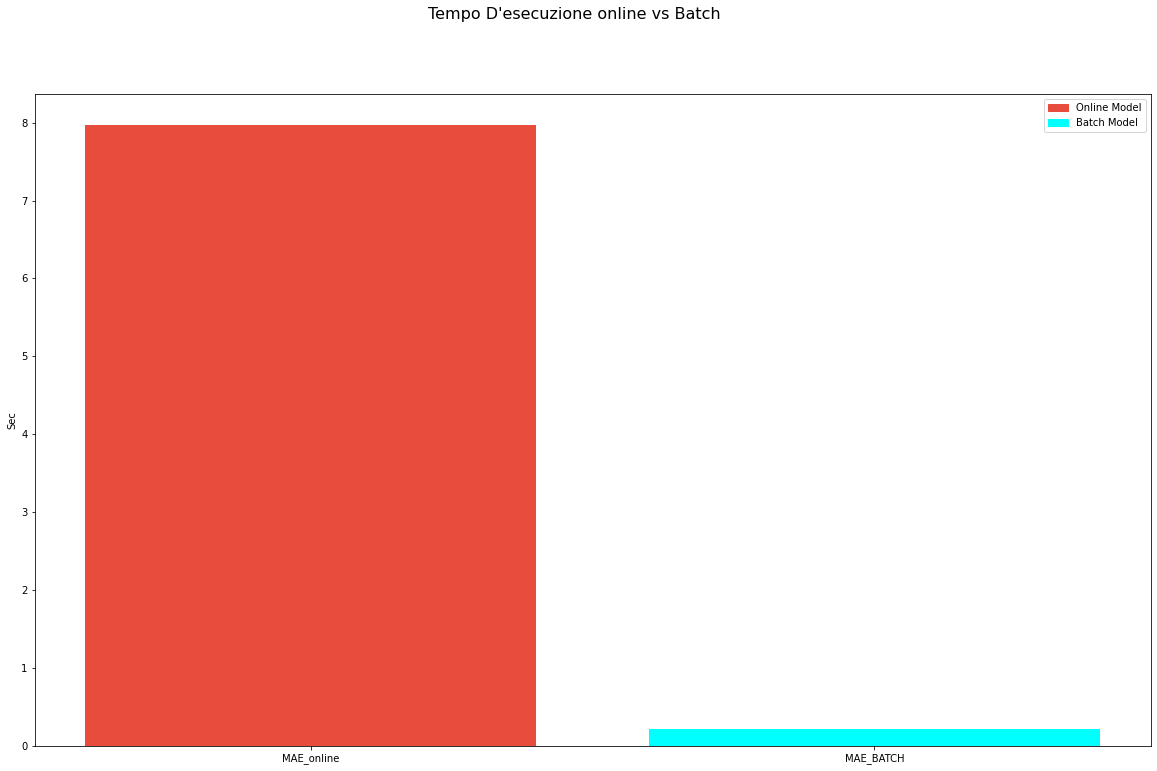

In [233]:


fig, ax = plt.subplots(figsize=(20, 12))

fig.suptitle('Tempo D\'esecuzione online vs Batch',  fontsize=16)

ax.bar(height=[7.974549770355225,0.22284626960754395], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax.set_ylabel('Sec')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax.legend(handles=[red_patch, cyan_patch])

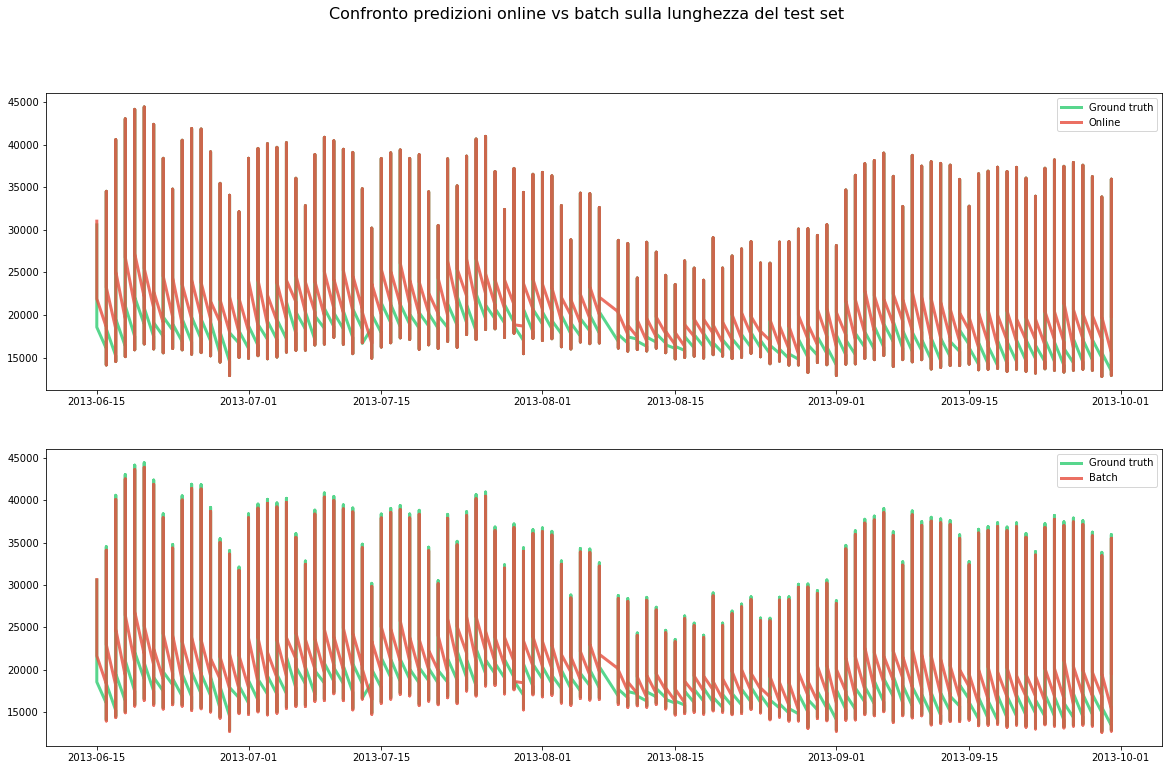

In [218]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(dates_ml_online[5947::], Y_test_mlp, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(dates_ml_online[5947::], Y_test_mlp, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(dates_ml_online[5947::], y_preds_ml_online[5947::], lw=3, color='#e74c3c', alpha=0.8, label='Online')
ax2.plot(dates_ml_online[5947::], result_mlpBatch, lw=3, color='#e74c3c', alpha=0.8, label='Batch')
ax1.legend()
ax2.legend()

## KNN Regressor Batch vs Online

### KNN regressor Online

100%|██████████| 8496/8496 [00:00<00:00, 11524.08it/s]


Execution time: 0.7407064437866211 seconds


Text(0.5, 1.0, 'MSE: 42,796,259.707633')

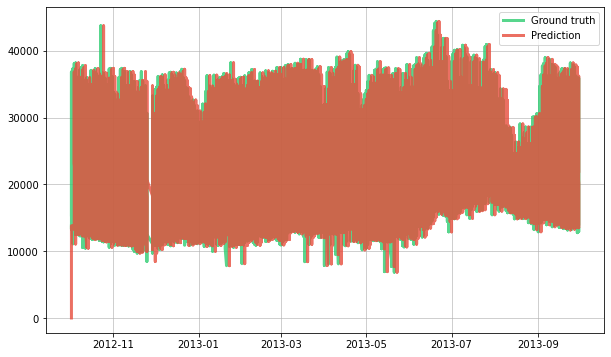

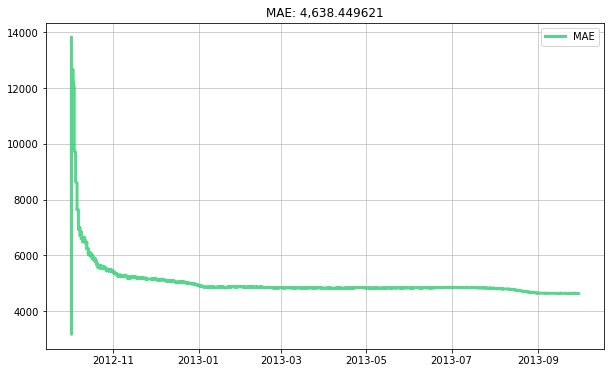

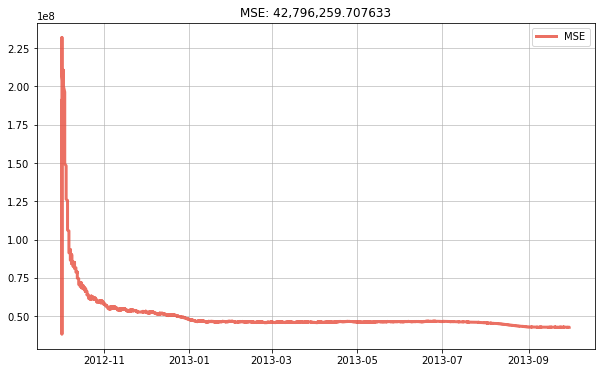

In [77]:

metric_mae_knnreg = metrics.MAE()
metric_mse_knnreg = metrics.MSE()

dates_knnreg = []
y_trues_knnreg = []
y_preds_knnreg = []
metrics_MAE_knnreg = []
metrics_MSE_knnreg = []

X_y = initial_iter_idraulic()
model = compose.Select( )
model |= neighbors.KNNRegressor(
       window_size= 50,
       n_neighbors=10
)

# get the start time
st = time.time()

for i in tqdm(range(0,8496)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go

       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric_mae_knnreg.update(y, y_pred)
       metric_mse_knnreg.update(y, y_pred)
       metrics_MAE_knnreg.append(metric_mae_knnreg.get())
       metrics_MSE_knnreg.append(metric_mse_knnreg.get())


       # Store the true value and the prediction
       dates_knnreg.append(x['date'])
       y_trues_knnreg.append(y)
       y_preds_knnreg.append(y_pred)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_knnreg, y_trues_knnreg, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates_knnreg, y_preds_knnreg, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_knnreg, metrics_MAE_knnreg, lw=3, color='#2ecc71', alpha=0.8, label='MAE')
ax.legend()
ax.set_title(metric_mae_knnreg)


fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_knnreg, metrics_MSE_knnreg, lw=3, color='#e74c3c', alpha=0.8, label='MSE')
ax.legend()
ax.set_title(metric_mse_knnreg)

In [78]:
ax.legend()
X_y = initial_iter_idraulic()
model = compose.Select()
X_y = initial_iter_idraulic()
model = compose.Select()
model |= neighbors.KNNRegressor(
       window_size=50,
       n_neighbors=10
)

evaluate.progressive_val_score(
       dataset=X_y,
       model=model,
       metric=metrics.MAE(),
       moment='date',
       delay=dt.timedelta(hours=3),
       print_every=3000
)

[3,000] MAE: 8,146.29658
[6,000] MAE: 8,156.093228


MAE: 7,632.871277

In [79]:
ax.legend()
X_y = initial_iter_idraulic()
model = compose.Select()
X_y = initial_iter_idraulic()
model = compose.Select()
model |= neighbors.KNNRegressor(
       window_size=50,
       n_neighbors=10
)

evaluate.progressive_val_score(
       dataset=X_y,
       model=model,
       metric=metrics.MSE(),
       moment='date',
       delay=dt.timedelta(hours=3),
       print_every=3000
)

[3,000] MSE: 87,638,904.651586
[6,000] MSE: 85,883,458.07814


MSE: 76,816,720.473762

### KNN regressor Batch

In [142]:
X_knm = dati['Water_volume'].to_numpy()
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return X, y

# split into samples
X_knm, y_knm = split_sequence(X_knm, 1)

X_train_knm, X_test_knm, Y_train_knm, Y_test_knm = train_test_split(X_knm, y_knm, random_state=1, train_size=0.7, shuffle=False)

# get the start time
st = time.time()

neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train_knm, Y_train_knm)

result_knnreg = neigh.predict(X_test_knm)

et = time.time()

# get the execution time

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 0.014305830001831055 seconds


### Confronto KNN regressor Batch vs KNN regressor Online

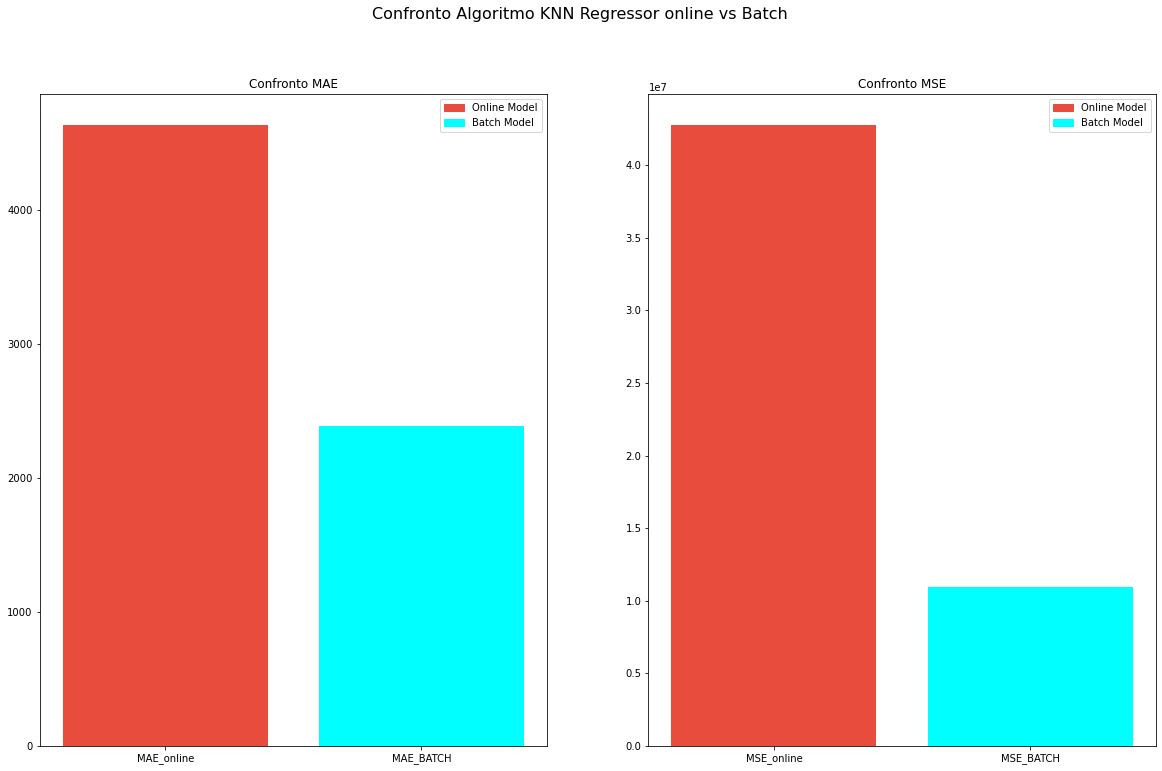

In [226]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo KNN Regressor online vs Batch',  fontsize=16)

ax1.bar(height=[metrics_MAE_knnreg[-1],mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[metrics_MSE_knnreg[-1],mean_squared_error(Y_test_knm, neigh.predict(X_test_knm))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

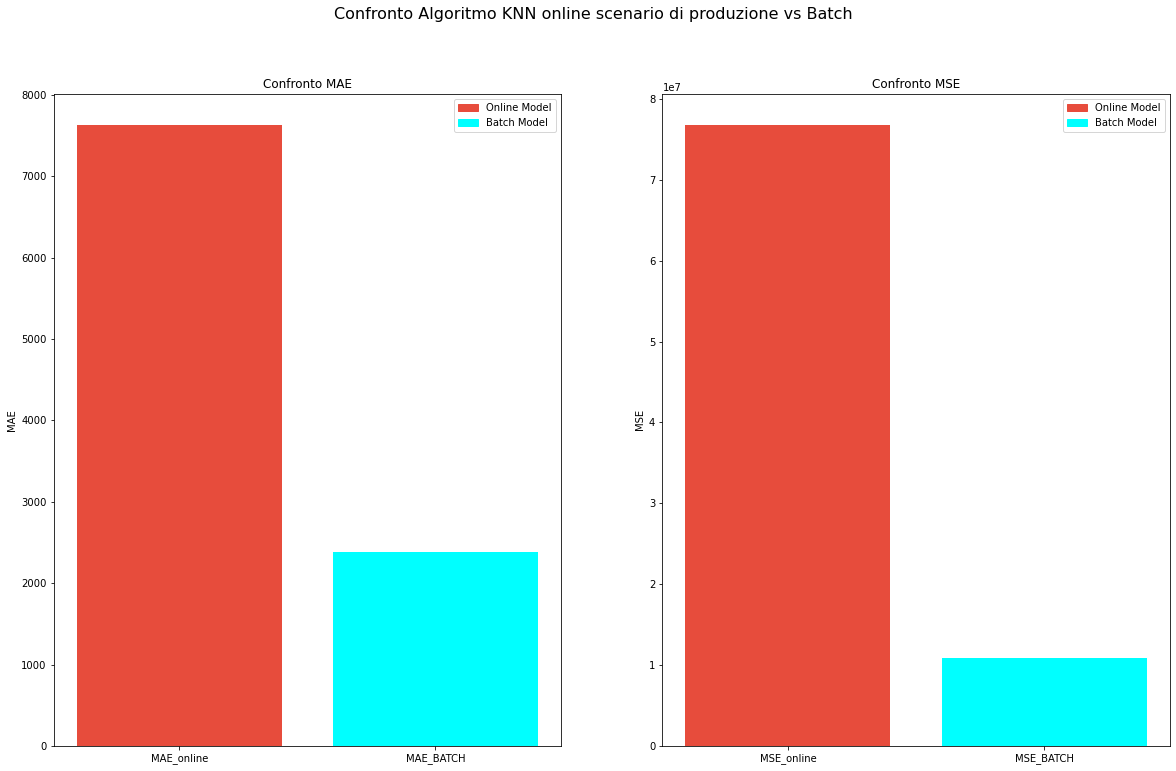

In [227]:
ax2.set_title('Confronto MSE')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo KNN online scenario di produzione vs Batch', fontsize=16)

ax1.bar(height=[7632.871277, mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm))], x=['MAE_online', 'MAE_BATCH'],
        color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax1.set_ylabel('MAE')
ax2.bar(height=[76816720.473762, mean_squared_error(Y_test_knm, neigh.predict(X_test_knm))], x=['MSE_online', 'MSE_BATCH'],
        color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')
ax2.set_ylabel('MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

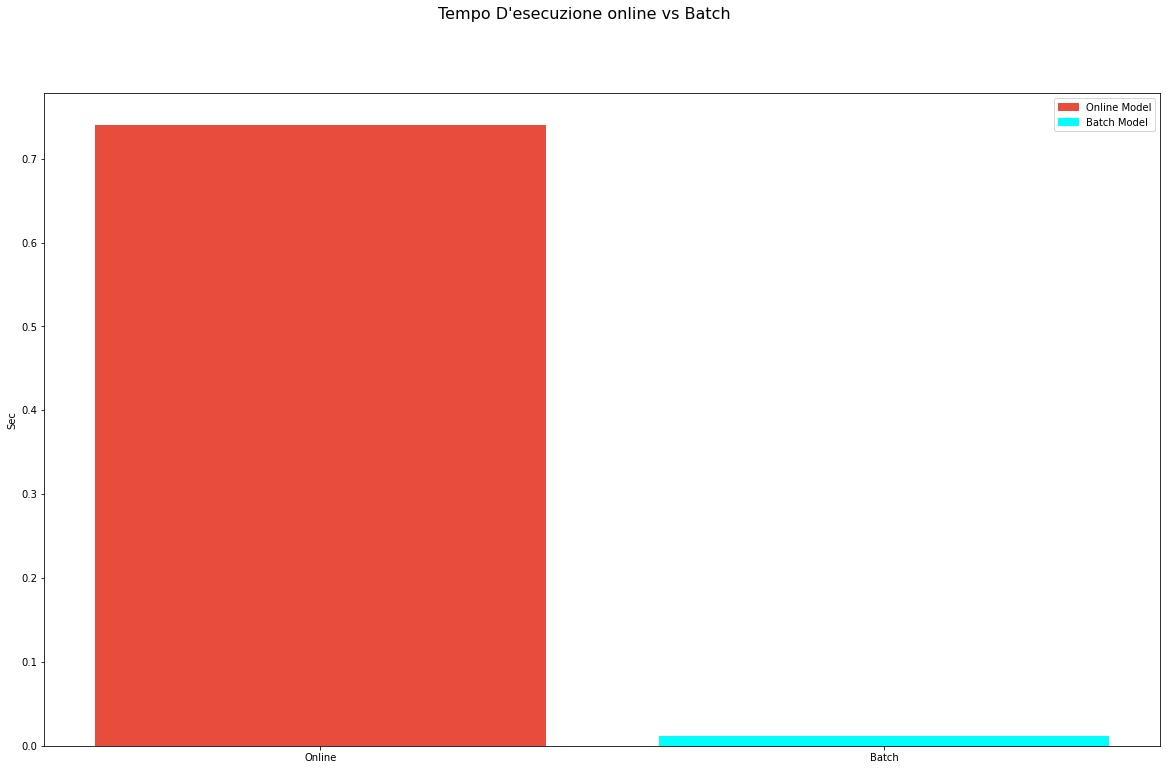

In [234]:
fig, ax = plt.subplots(figsize=(20, 12))

fig.suptitle('Tempo D\'esecuzione online vs Batch',  fontsize=16)

ax.bar(height=[0.74070644, 0.011910], x=['Online','Batch'], color=['#e74c3c', 'cyan'])
ax.set_ylabel('Sec')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax.legend(handles=[red_patch, cyan_patch])

Text(0.5, 1.0, 'BATCH')

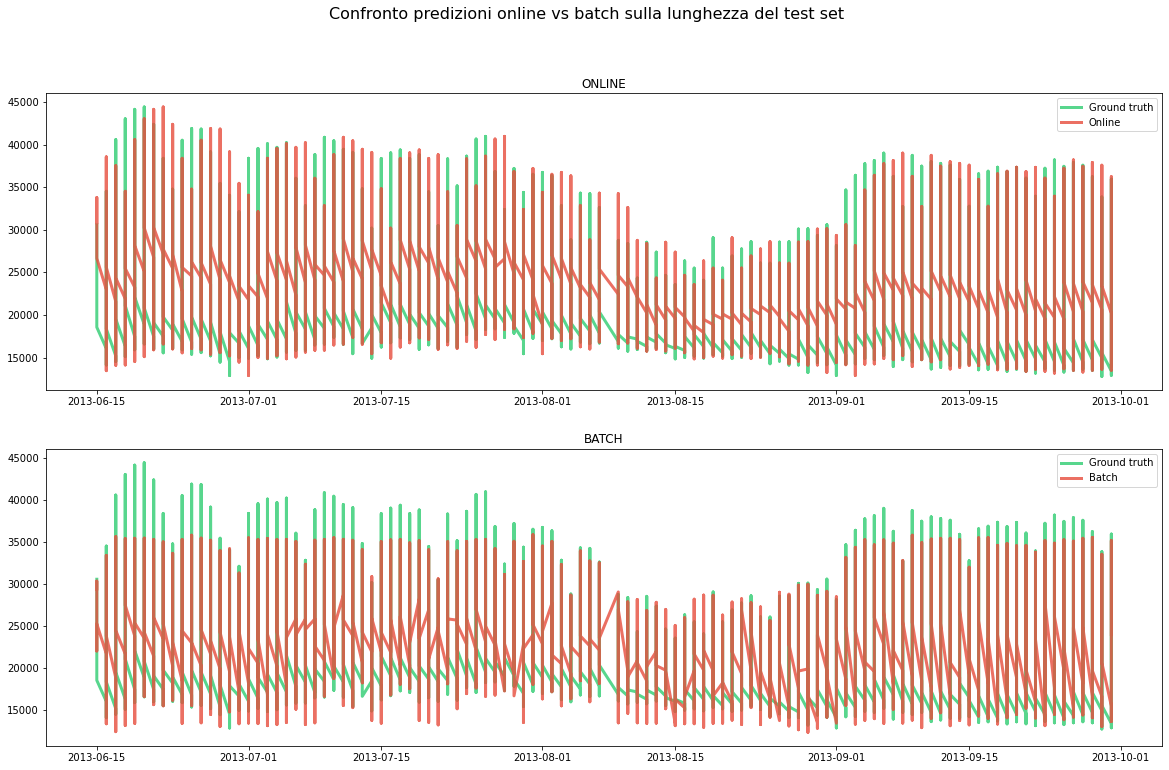

In [220]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(dates_knnreg[5947::], Y_test_knm, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(dates_knnreg[5947::], Y_test_knm, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(dates_knnreg[5947::], y_preds_knnreg[5947::], lw=3, color='#e74c3c', alpha=0.8, label='Online')
ax2.plot(dates_knnreg[5947::], result_knnreg, lw=3, color='#e74c3c', alpha=0.8, label='Batch')
ax1.legend()
ax2.legend()
ax1.set_title('ONLINE')
ax2.set_title('BATCH')

## Random Forest Online vs Random Forest Batch

### Random Forest Online

100%|██████████| 8496/8496 [00:31<00:00, 267.49it/s]


Execution time: 31.764575004577637 seconds


Text(0.5, 1.0, 'MSE: 6,154,003.267389')

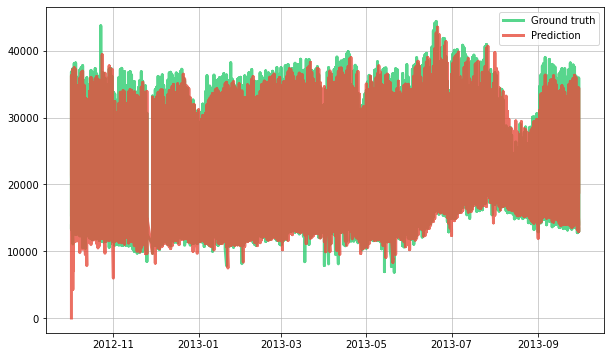

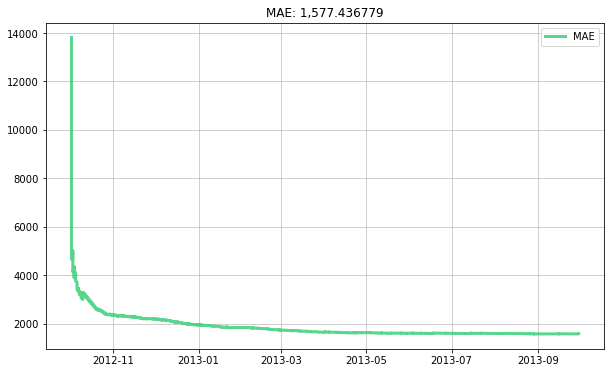

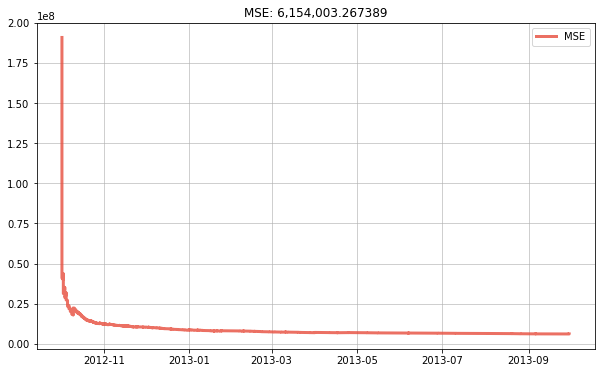

In [88]:

metric_mae_ranFor_on = metrics.MAE()
metric_mse_ranFor_on = metrics.MSE()

dates_ranFor_on = []
y_trues_ranFor_on = []
y_preds_ranFor_on = []
metrics_MAE_ranFor_on = []
metrics_MSE_ranFor_on = []

X_y = initial_iter_idraulic()
# '', 'hour', 'days', 'Count_days'
model = compose.Select('','hour','days')
model |= preprocessing.StandardScaler()

model |= ensemble.AdaptiveRandomForestRegressor()

# get the start time
st = time.time()

for i in tqdm(range(0,8496)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric_mae_ranFor_on.update(y, y_pred)
       metric_mse_ranFor_on.update(y, y_pred)
       metrics_MAE_ranFor_on.append(metric_mae_ranFor_on.get())
       metrics_MSE_ranFor_on.append(metric_mse_ranFor_on.get())

       # Store the true value and the prediction
       dates_ranFor_on.append(x['date'])
       y_trues_ranFor_on.append(y)
       y_preds_ranFor_on.append(y_pred)


et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')


# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ranFor_on, y_trues_ranFor_on, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates_ranFor_on, y_preds_ranFor_on, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ranFor_on, metrics_MAE_ranFor_on, lw=3, color='#2ecc71', alpha=0.8, label='MAE')
ax.legend()
ax.set_title(metric_mae_ranFor_on)


fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ranFor_on, metrics_MSE_ranFor_on, lw=3, color='#e74c3c', alpha=0.8, label='MSE')
ax.legend()
ax.set_title(metric_mse_ranFor_on)

In [89]:
X_y = initial_iter_idraulic()
# '', 'hour', 'days', 'Count_days'
model = compose.Select('','hour','days')
model |= preprocessing.StandardScaler()

model |= ensemble.AdaptiveRandomForestRegressor()

evaluate.progressive_val_score(
       dataset=X_y,
       model=model,
       metric=metrics.MAE(),
       moment='date',
       delay=dt.timedelta(hours=3),
       print_every=3000
)

[3,000] MAE: 2,890.030643
[6,000] MAE: 2,294.683863


MAE: 2,171.559276

In [90]:
X_y = initial_iter_idraulic()
# '', 'hour', 'days', 'Count_days'
model = compose.Select('','hour','days')
model |= preprocessing.StandardScaler()

model |= ensemble.AdaptiveRandomForestRegressor()

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MSE(),
       moment='date',
       delay=dt.timedelta(hours=3),
       print_every=3000
)

[3,000] MSE: 22,920,803.42271
[6,000] MSE: 15,281,292.138187


MSE: 14,962,137.707209

### Random Forest Batch

In [149]:
X_RF = dati[['Water_volume', 'hour', 'days']].to_numpy()
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return X, y

# split into samples
X_RF, y_RF = split_sequence(X_RF, 1)

X_RF = np.array(X_RF).reshape((8495,3))

y_RF = np.array(y_RF)
y_RF = y_RF[:, [0]]



In [99]:
X

array([[1.38152e+04, 0.00000e+00, 2.00000e+00],
       [1.32900e+04, 1.00000e+00, 2.00000e+00],
       [1.34162e+04, 2.00000e+00, 2.00000e+00],
       ...,
       [2.71887e+04, 2.00000e+01, 3.00000e+01],
       [2.26309e+04, 2.10000e+01, 3.00000e+01],
       [1.98585e+04, 2.20000e+01, 3.00000e+01]])

In [150]:
X_train_RF, X_test_RF, Y_train_RF, Y_test_RF = train_test_split(X_RF, y_RF, random_state=1, train_size=0.7, shuffle=False)

In [151]:

# get the start time
st = time.time()

regr_random_forest = RandomForestRegressor(max_depth=25, random_state=0).fit(X_train_RF, Y_train_RF)
result_random_forest = regr_random_forest.predict(X_test_RF).reshape(-1,1)

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

/tmp/ipykernel_20010/4241216155.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr_random_forest = RandomForestRegressor(max_depth=25, random_state=0).fit(X_train_RF, Y_train_RF)


Execution time: 1.0367493629455566 seconds


### Confronto Random Forest Batch vs Random Forest Online

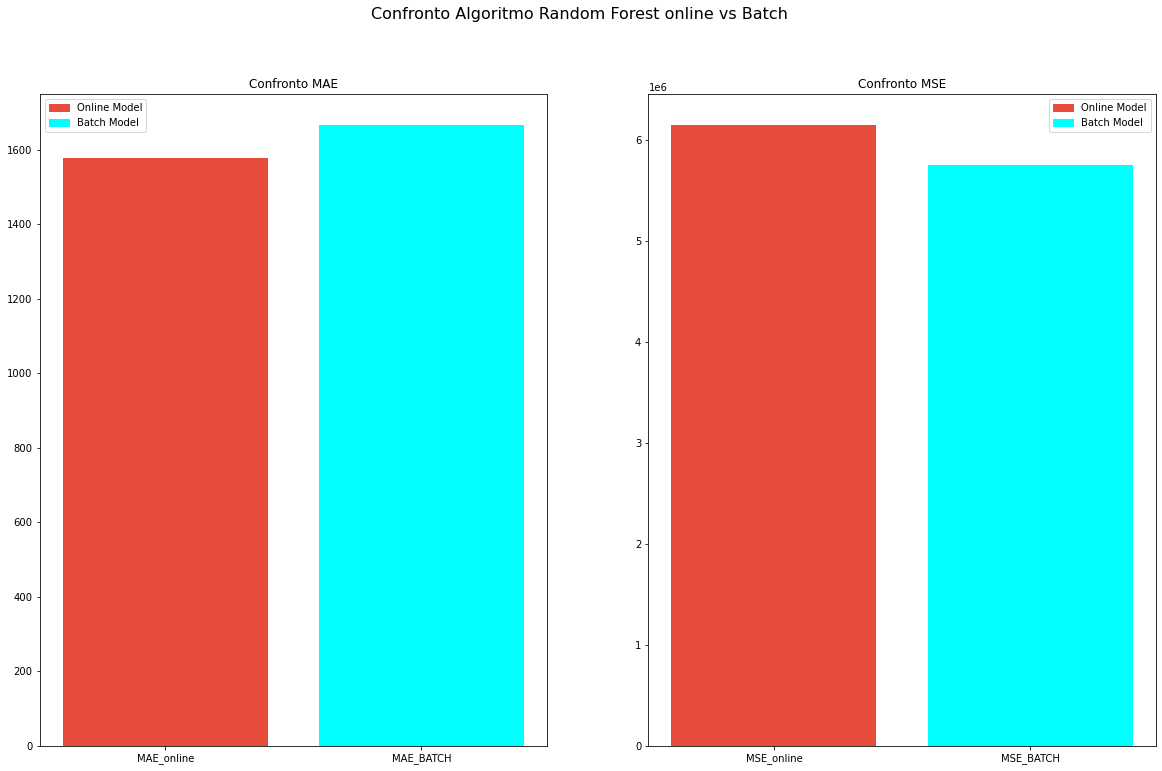

In [229]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Random Forest online vs Batch',  fontsize=16)

ax1.bar(height=[metrics_MAE_ranFor_on[-1],mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[metrics_MSE_ranFor_on[-1],mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

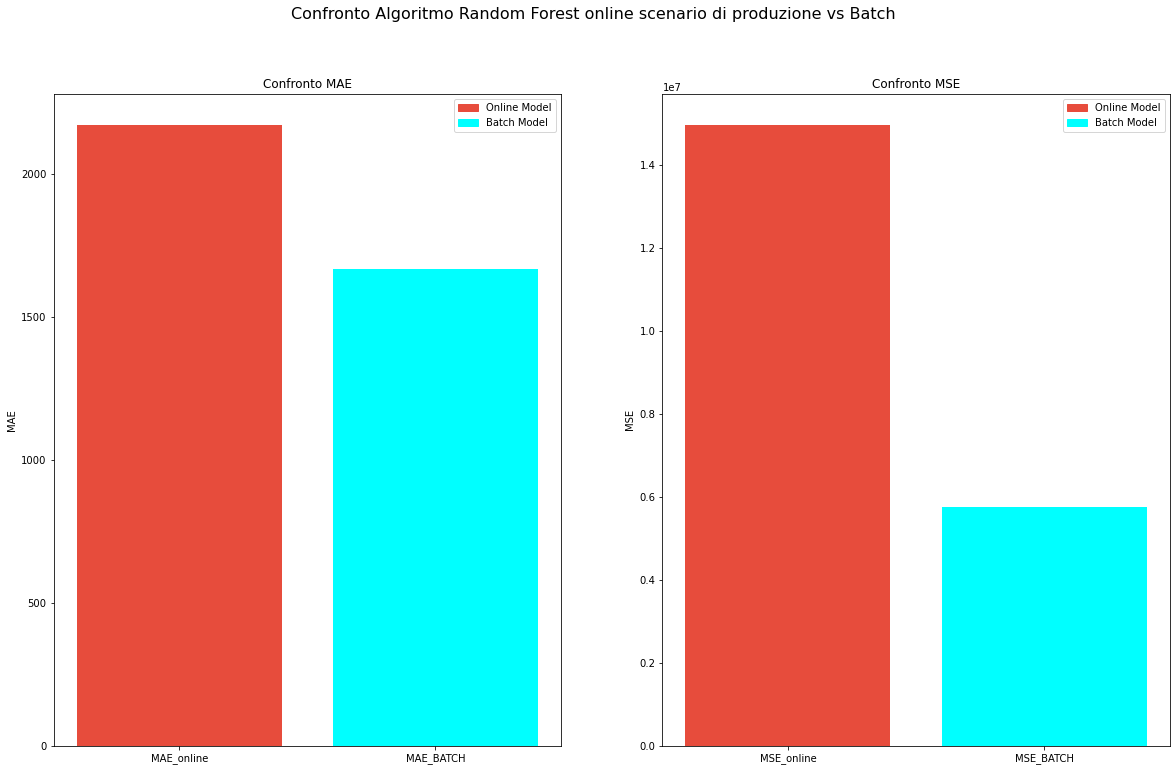

In [230]:
ax2.set_title('Confronto MSE')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Random Forest online scenario di produzione vs Batch', fontsize=16)

ax1.bar(height=[2171.559276, mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF))], x=['MAE_online', 'MAE_BATCH'],
        color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax1.set_ylabel('MAE')
ax2.bar(height=[14962137.707209, mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF))], x=['MSE_online', 'MSE_BATCH'],
        color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')
ax2.set_ylabel('MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

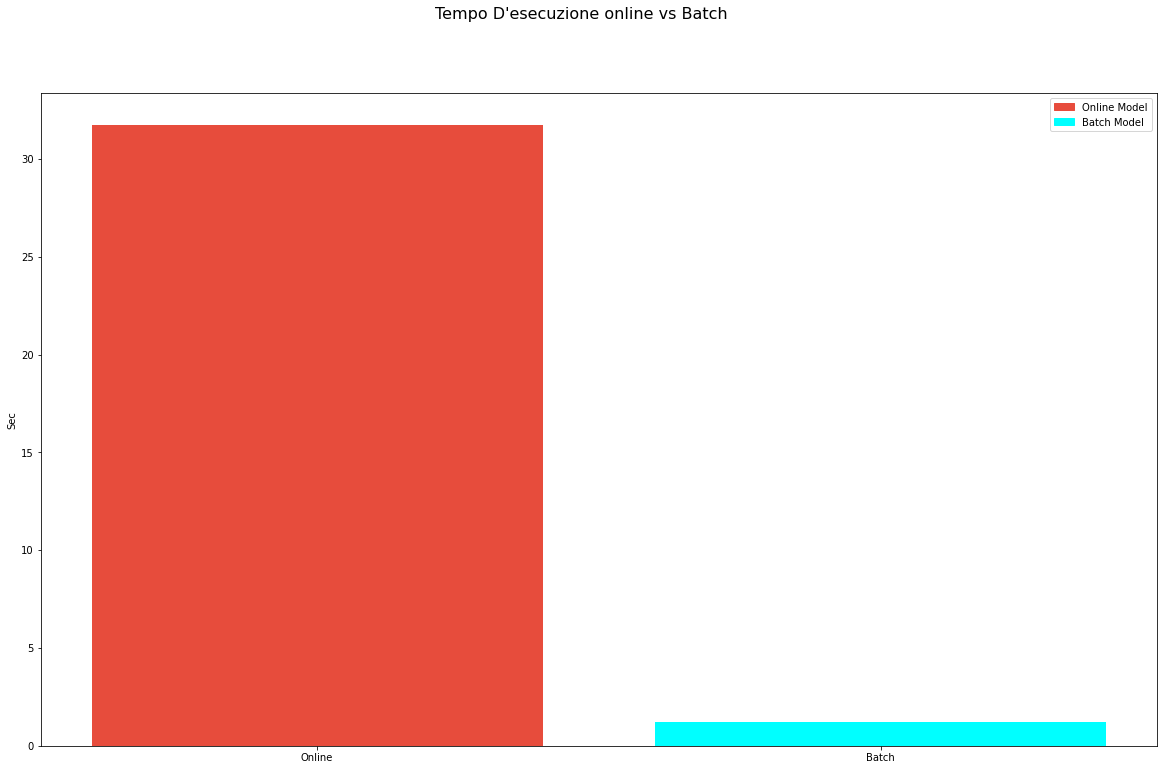

In [232]:
fig, ax = plt.subplots(figsize=(20, 12))

fig.suptitle('Tempo D\'esecuzione online vs Batch',  fontsize=16)

ax.bar(height=[31.76457500, 1.23618531], x=['Online','Batch'], color=['#e74c3c', 'cyan'])
ax.set_ylabel('Sec')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax.legend(handles=[red_patch, cyan_patch])

Text(0.5, 1.0, 'BATCH')

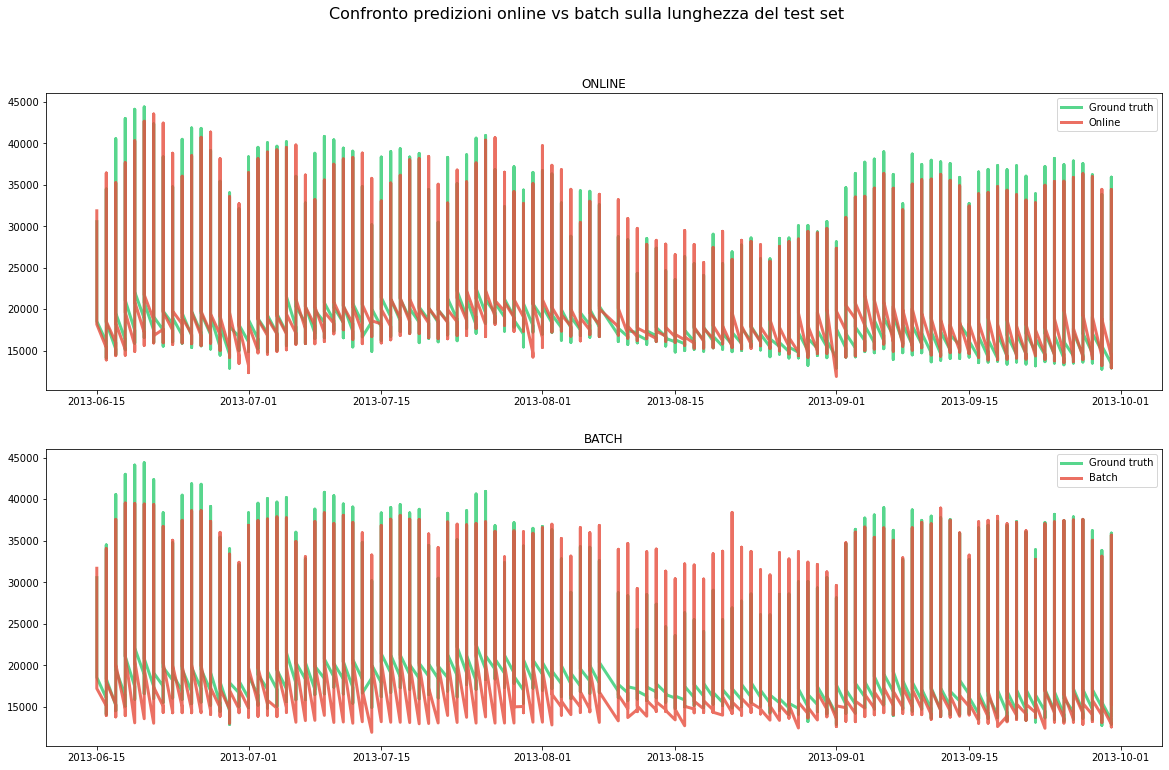

In [219]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(dates_ranFor_on[5947::], Y_test_RF, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(dates_ranFor_on[5947::], Y_test_RF, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(dates_ranFor_on[5947::], y_preds_ranFor_on[5947::], lw=3, color='#e74c3c', alpha=0.8, label='Online')
ax2.plot(dates_ranFor_on[5947::], result_random_forest, lw=3, color='#e74c3c', alpha=0.8, label='Batch')
ax1.legend()
ax2.legend()
ax1.set_title('ONLINE')
ax2.set_title('BATCH')

## Decision Tree Online vs Decision Tree Batch

### Decision Tree Online

100%|██████████| 8496/8496 [00:10<00:00, 772.95it/s]


Execution time: 10.994019746780396 seconds


Text(0.5, 1.0, 'MSE: 55,240,196.465013')

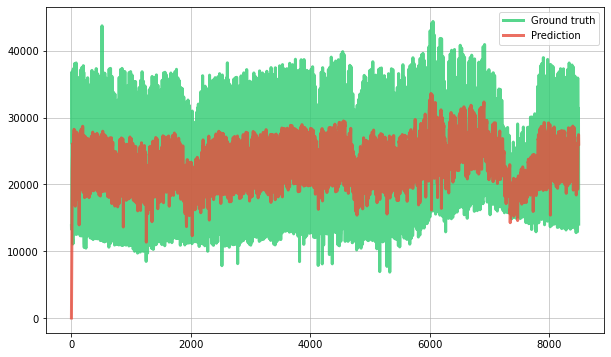

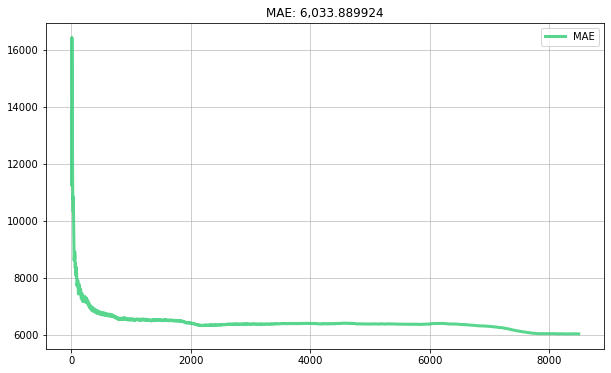

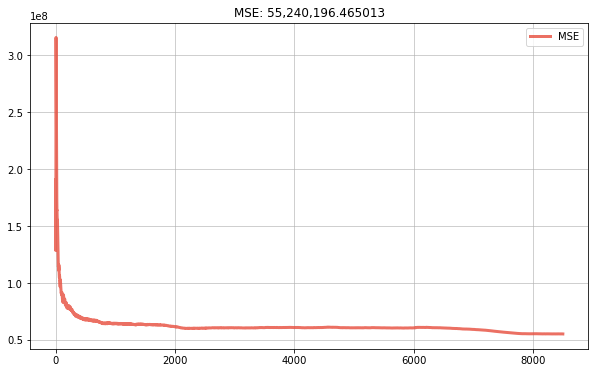

In [108]:
metric_mae_dec_tree = metrics.MAE()
metric_mse_dec_tree = metrics.MSE()

dates_dec_tree = []
y_trues_dec_tree = []
y_preds_dec_tree = []
metrics_MAE_dec_tree = []
metrics_MSE_dec_tree = []

X_y = initial_iter_idraulic()

base_model = tree.HoeffdingTreeRegressor(grace_period=50)
model = compose.Select()
model |= ensemble.SRPRegressor(
       model=base_model,
       training_method='patches',
       n_models=10
)

# get the start time
st = time.time()

for i in tqdm(range(0,8496)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric_mae_dec_tree.update(y, y_pred)
       metric_mse_dec_tree.update(y, y_pred)
       metrics_MAE_dec_tree.append(metric_mae_dec_tree.get())
       metrics_MSE_dec_tree.append(metric_mse_dec_tree.get())

       # Store the true value and the prediction
       dates_dec_tree.append(i)
       y_trues_dec_tree.append(y)
       y_preds_dec_tree.append(y_pred)

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_dec_tree, y_trues_dec_tree, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates_dec_tree, y_preds_dec_tree, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_dec_tree, metrics_MAE_dec_tree, lw=3, color='#2ecc71', alpha=0.8, label='MAE')
ax.legend()
ax.set_title(metric_mae_dec_tree)


fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_dec_tree, metrics_MSE_dec_tree, lw=3, color='#e74c3c', alpha=0.8, label='MSE')
ax.legend()
ax.set_title(metric_mse_dec_tree)

In [111]:
X_y = initial_iter_idraulic()

base_model = tree.HoeffdingTreeRegressor(grace_period=50)
model = compose.Select()
model |= ensemble.SRPRegressor(
       model=base_model,
       training_method='patches',
       n_models=10
)

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MAE(),
       moment='date',
       delay=dt.timedelta(hours=3),
       print_every=3000
)

[3,000] MAE: 6,866.947983
[6,000] MAE: 6,804.022777


MAE: 6,437.296063

In [112]:
X_y = initial_iter_idraulic()

base_model = tree.HoeffdingTreeRegressor(grace_period=50)
model = compose.Select()
model |= ensemble.SRPRegressor(
       model=base_model,
       training_method='patches',
       n_models=10
)

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MSE(),
       moment='date',
       delay=dt.timedelta(hours=3),
       print_every=3000
)

[3,000] MSE: 65,678,795.571842
[6,000] MSE: 63,986,398.205531


MSE: 57,834,254.995266

### Decision Tree Batch

In [154]:
X_DT = dati['Water_volume'].to_numpy()


def split_sequence(sequence, n_steps):
       X, y = list(), list()
       for i in range(len(sequence)):
              # find the end of this pattern
              end_ix = i + n_steps
              # check if we are beyond the sequence
              if end_ix > len(sequence) - 1:
                     break
              # gather input and output parts of the pattern
              seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
              X.append(seq_x)
              y.append(seq_y)
       return X, y


# split into samples
X_DT, y_DT = split_sequence(X_DT, 1)

X_train_DT, X_test_DT, Y_train_DT, Y_test_DT = train_test_split(X_DT, y_DT, random_state=1, train_size=0.7, shuffle=False)

# get the start time
st = time.time()

regressor_dec_tree = DecisionTreeRegressor(random_state=0).fit(X_train_DT, Y_train_DT)

result_dec_tree = regressor_dec_tree.predict(X_test_DT)

et = time.time()

# get the execution time

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 0.016078472137451172 seconds


### Confronto Decision Tree Batch vs Decision Tree Online

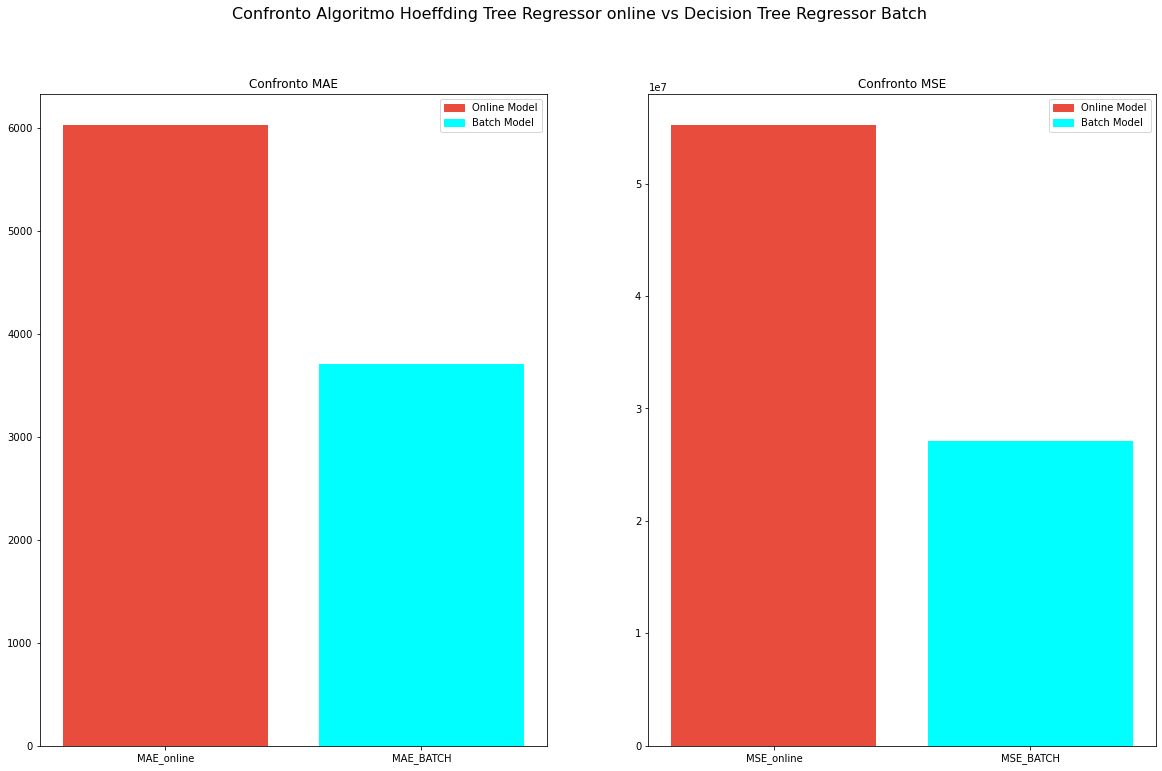

In [235]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Hoeffding Tree Regressor online vs Decision Tree Regressor Batch',  fontsize=16)

ax1.bar(height=[metrics_MAE_dec_tree[-1],mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[metrics_MSE_dec_tree[-1],mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

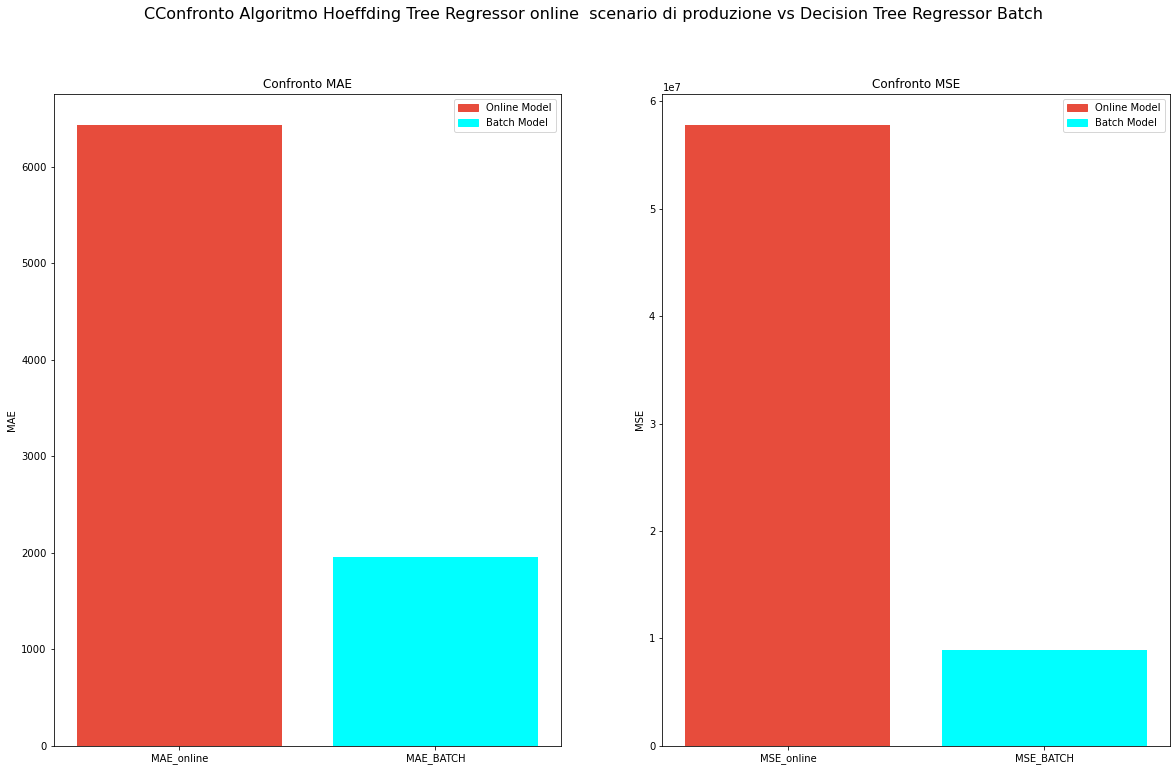

In [236]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 12))

fig.suptitle('CConfronto Algoritmo Hoeffding Tree Regressor online  scenario di produzione vs Decision Tree Regressor Batch',  fontsize=16)

ax1.bar(height=[6437.296063,mean_absolute_error(Y_test_DT, regr_mlp.predict(X_test_DT))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax1.set_ylabel('MAE')
ax2.bar(height=[57834254.995266,mean_squared_error(Y_test_DT, regr_mlp.predict(X_test_DT))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')
ax2.set_ylabel('MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

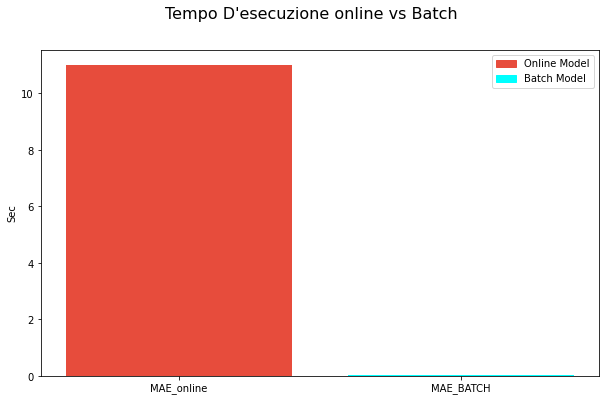

In [237]:
fig, ax = plt.subplots(figsize=(10, 6))

fig.suptitle('Tempo D\'esecuzione online vs Batch',  fontsize=16)

ax.bar(height=[10.9940197,0.0190103], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax.set_ylabel('Sec')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax.legend(handles=[red_patch, cyan_patch])

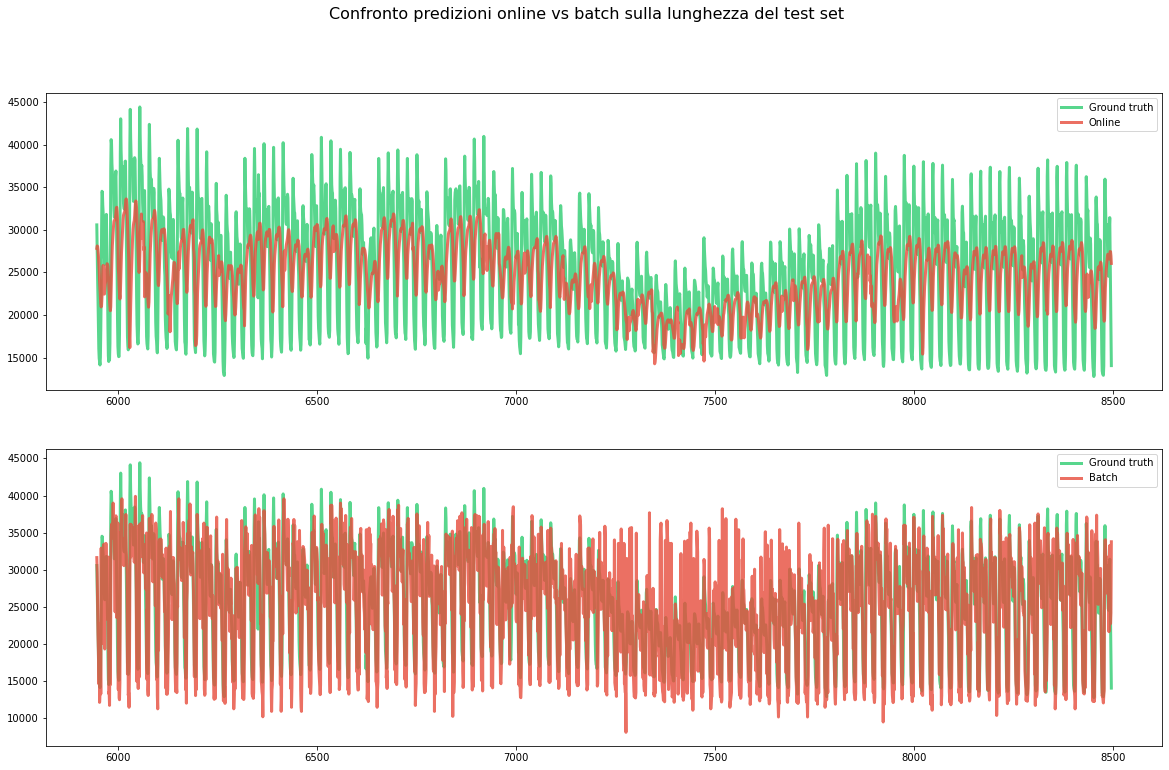

In [217]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(dates_dec_tree[5947::], Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(dates_dec_tree[5947::], Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(dates_dec_tree[5947::], y_preds_dec_tree[5947::], lw=3, color='#e74c3c', alpha=0.8, label='Online')
ax2.plot(dates_dec_tree[5947::], result_dec_tree, lw=3, color='#e74c3c', alpha=0.8, label='Batch')
ax1.legend()
ax2.legend()

## Confronto Totale

Text(0.5, 1.0, 'Confronto MSE')

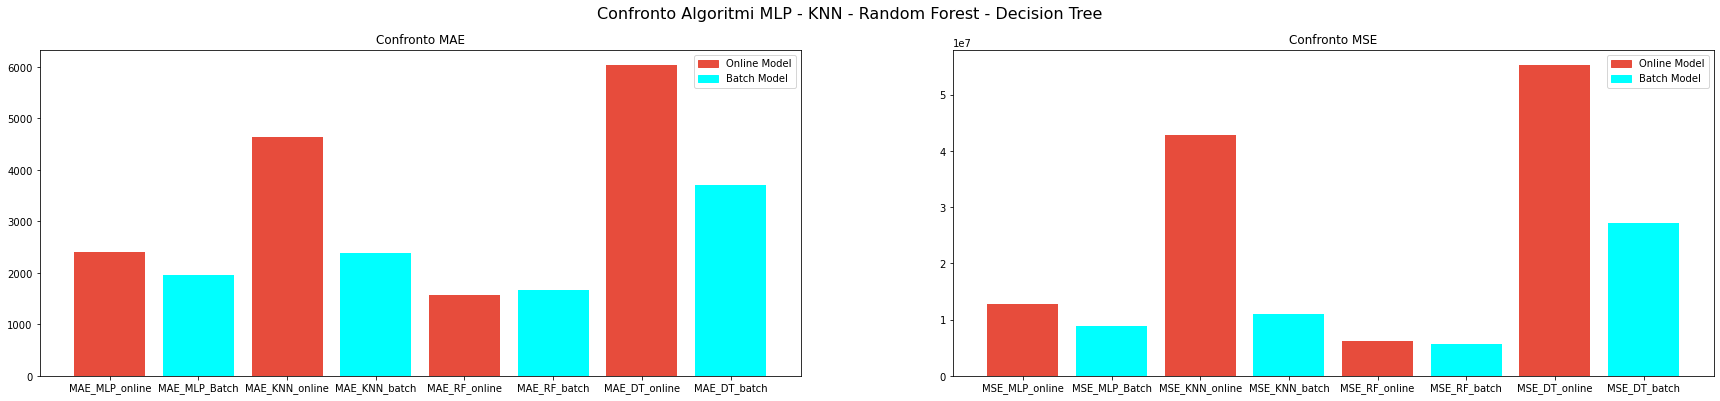

In [184]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(30, 6))

fig.suptitle('Confronto Algoritmi MLP - KNN - Random Forest - Decision Tree',  fontsize=16)

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')


ax1.bar(height=[
       metrics_MAE_ml_online[-1],mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
       metrics_MAE_knnreg[-1], mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
       metrics_MAE_ranFor_on[-1],mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
       metrics_MAE_dec_tree[-1], mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))
                ],
       x=['MAE_MLP_online','MAE_MLP_Batch','MAE_KNN_online','MAE_KNN_batch','MAE_RF_online','MAE_RF_batch','MAE_DT_online','MAE_DT_batch'],
        color=['#e74c3c', 'cyan'])
ax1.legend(handles=[red_patch, cyan_patch])
ax1.set_title('Confronto MAE')
ax2.bar(height=[
       metrics_MSE_ml_online[-1],mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
       metrics_MSE_knnreg[-1], mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
       metrics_MSE_ranFor_on[-1],mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
       metrics_MSE_dec_tree[-1], mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))
                ],
       x=['MSE_MLP_online','MSE_MLP_Batch','MSE_KNN_online','MSE_KNN_batch','MSE_RF_online','MSE_RF_batch','MSE_DT_online','MSE_DT_batch'],
       color=['#e74c3c', 'cyan'])
ax2.legend(handles=[red_patch, cyan_patch])
ax2.set_title('Confronto MSE')

Text(0.5, 1.0, 'Confronto MSE')

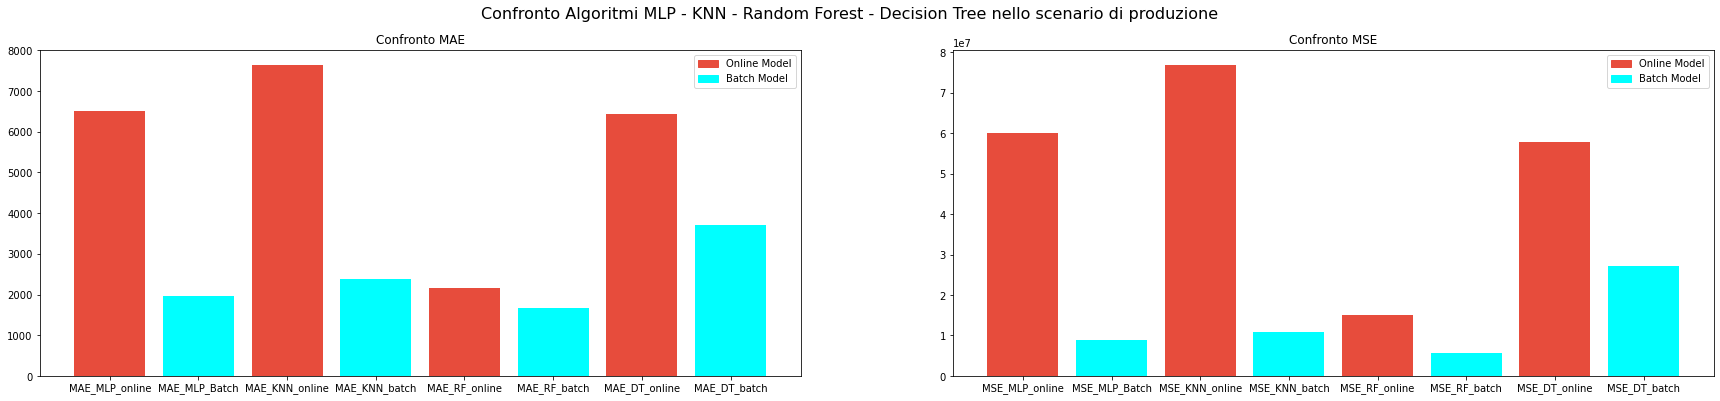

In [183]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(30, 6))

fig.suptitle('Confronto Algoritmi MLP - KNN - Random Forest - Decision Tree nello scenario di produzione',  fontsize=16)

ax1.bar(height=[
       6514.380636,mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
       7632.871277, mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
       2171.559276,mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
       6437.296063, mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))
                ],
       x=['MAE_MLP_online','MAE_MLP_Batch','MAE_KNN_online','MAE_KNN_batch','MAE_RF_online','MAE_RF_batch','MAE_DT_online','MAE_DT_batch'],
        color=['#e74c3c', 'cyan'],
       )
red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax1.set_title('Confronto MAE')
ax2.bar(height=[
       60000966.283311,mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
       76816720.473762, mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
       14962137.707209,mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
       57834254.995266, mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))
                ],
       x=['MSE_MLP_online','MSE_MLP_Batch','MSE_KNN_online','MSE_KNN_batch','MSE_RF_online','MSE_RF_batch','MSE_DT_online','MSE_DT_batch'],
       color=['#e74c3c', 'cyan'])
ax2.legend(handles=[red_patch, cyan_patch])
ax2.set_title('Confronto MSE')




Text(0, 0.5, 'Sec')

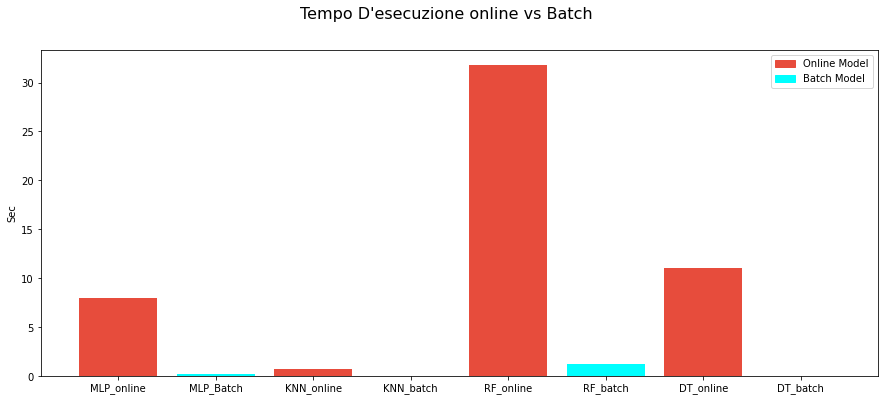

In [188]:
fig, ax = plt.subplots(figsize=(15, 6))

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')

fig.suptitle('Tempo D\'esecuzione online vs Batch',  fontsize=16)

ax.bar(
       height=[7.974549770355225,0.22284626960754395, 0.74070644, 0.011910, 31.76457500, 1.23618531, 10.9940197, 0.0190103],
       x=['MLP_online','MLP_Batch','KNN_online','KNN_batch','RF_online','RF_batch','DT_online','DT_batch'],
       color=['#e74c3c', 'cyan']
)
ax.legend(handles=[red_patch, cyan_patch])
ax.set_ylabel('Sec')

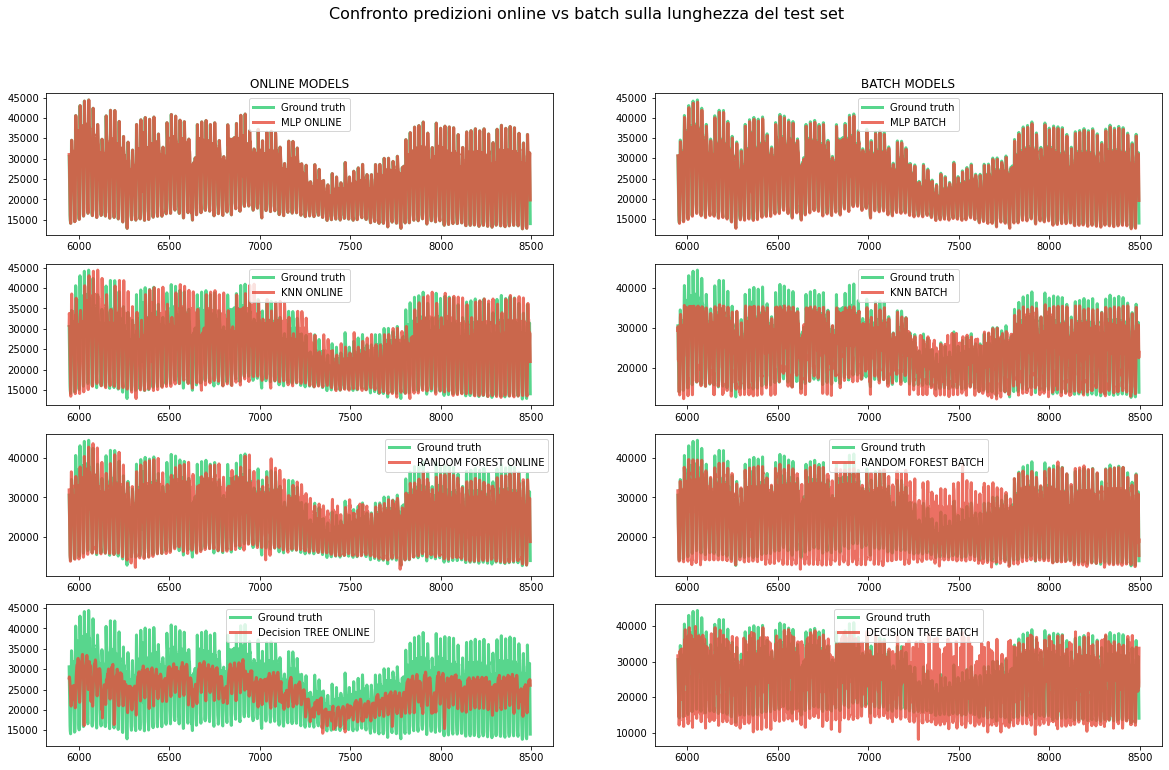

In [221]:
# Plot the results
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4,2,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(dates_dec_tree[5947::], Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(dates_dec_tree[5947::], Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax3.plot(dates_dec_tree[5947::], Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax4.plot(dates_dec_tree[5947::], Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax5.plot(dates_dec_tree[5947::], Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax6.plot(dates_dec_tree[5947::], Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax7.plot(dates_dec_tree[5947::], Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax8.plot(dates_dec_tree[5947::], Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')

ax1.plot(dates_dec_tree[5947::], y_preds_ml_online[5947::], lw=3, color='#e74c3c', alpha=0.8, label='MLP ONLINE')

ax2.plot(dates_dec_tree[5947::], result_mlpBatch, lw=3, color='#e74c3c', alpha=0.8, label='MLP BATCH')

ax3.plot(dates_dec_tree[5947::], y_preds_knnreg[5947::], lw=3, color='#e74c3c', alpha=0.8, label='KNN ONLINE')

ax4.plot(dates_dec_tree[5947::], result_knnreg, lw=3, color='#e74c3c', alpha=0.8, label='KNN BATCH')

ax5.plot(dates_dec_tree[5947::], y_preds_ranFor_on[5947::], lw=3, color='#e74c3c', alpha=0.8, label='RANDOM FOREST ONLINE')

ax6.plot(dates_dec_tree[5947::], result_random_forest, lw=3, color='#e74c3c', alpha=0.8, label='RANDOM FOREST BATCH')

ax7.plot(dates_dec_tree[5947::], y_preds_dec_tree[5947::], lw=3, color='#e74c3c', alpha=0.8, label='Decision TREE ONLINE')

ax8.plot(dates_dec_tree[5947::], result_dec_tree, lw=3, color='#e74c3c', alpha=0.8, label='DECISION TREE BATCH')


ax1.set_title('ONLINE MODELS')
ax2.set_title('BATCH MODELS')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax7.legend()
ax8.legend()

## Complessità algoritmica

In questa fase dobbiamo recuperare in qualche modo la complessità algoritmica degli algoritmi utilizzati